# Feature Engineering

In [1]:
%matplotlib inline

# Filter warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 18})

In [2]:
# Create spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("project").getOrCreate()

# Load data

In [3]:
df_raw = spark.read.csv('../data/emdat_public_cleaned.csv', inferSchema=True, header=True) 
df = df_raw.toPandas() # convert into pandas df
print("Data size:", df.shape) # print data size
df.columns = [x.lower() for x in df.columns] # column names in lower case
df.head()

Data size: (16338, 20)


,iso,country,region,continent,year,disaster_type,latitude,longitude,local_time,start_month,total_deaths,no_injured,no_affected,no_homeless,total_affected,total_damages_('000_us$),cpi,local_hour,year_in_decade,no_occurrence
0,CPV,Cabo Verde,Western Africa,Africa,1900,Drought,NaN,NaN,None,NaN,11000.0,NaN,NaN,NaN,NaN,NaN,3.077091,NaN,1900,7.0
1,IND,India,Southern Asia,Asia,1900,Drought,NaN,NaN,None,NaN,1250000.0,NaN,NaN,NaN,NaN,NaN,3.077091,NaN,1900,7.0
2,GTM,Guatemala,Central America,Americas,1902,Earthquake,14.0,-91.0,20:20,4.0,2000.0,NaN,NaN,NaN,NaN,25000.0,3.200175,20.0,1900,10.0
3,GTM,Guatemala,Central America,Americas,1902,Volcanic activity,NaN,NaN,None,4.0,1000.0,NaN,NaN,NaN,NaN,NaN,3.200175,NaN,1900,10.0
4,GTM,Guatemala,Central America,Americas,1902,Volcanic activity,NaN,NaN,None,10.0,6000.0,NaN,NaN,NaN,NaN,NaN,3.200175,NaN,1900,10.0


# Data types & missing values
As indicated in the [data source](https://www.emdat.be), the missing values in some numerical columns should be set to zero. However, missing values in other columns such as local_hour, start_month will be imputed in data pre-processing 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16338 entries, 0 to 16337
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   iso                       16338 non-null  object 
 1   country                   16338 non-null  object 
 2   region                    16338 non-null  object 
 3   continent                 16338 non-null  object 
 4   year                      16338 non-null  int32  
 5   disaster_type             16338 non-null  object 
 6   latitude                  2739 non-null   float64
 7   longitude                 2739 non-null   float64
 8   local_time                1118 non-null   object 
 9   start_month               15949 non-null  float64
 10  total_deaths              11561 non-null  float64
 11  no_injured                3976 non-null   float64
 12  no_affected               9385 non-null   float64
 13  no_homeless               2438 non-null   float64
 14  total_

In [5]:
# Compute percentage of missing values
missing_values = (df.isnull().sum()/df.shape[0])*100

# Dataframe of missing values
missing_df = pd.DataFrame({
    'Variable': missing_values.index, 
    '% missing values': missing_values.values,
})
missing_df.sort_values(by='% missing values', ascending=False)\
        .reset_index(drop=True)

,Variable,% missing values
0,local_hour,93.157057
1,local_time,93.157057
2,no_homeless,85.077733
3,latitude,83.235402
4,longitude,83.235402
5,no_injured,75.664096
6,total_damages_('000_us$),67.450116
7,no_affected,42.557229
8,total_deaths,29.238585
9,total_affected,27.763496


In [8]:
# Fill missing values with zeros in  cols list
cols = [
    'total_deaths', 'no_injured', "total_damages_('000_us$)",
    'no_affected', 'no_homeless', 'total_affected'
]    
for col in cols:
    df[col] = df[col].fillna(0) 

# Continent count

In [9]:
df_cont = pd.DataFrame(df.continent.value_counts())
df_cont.reset_index(level=0,inplace=True)
df_cont.rename(columns = {'continent':'contnt_ct', 'index':'continent'},inplace=True)
df_cont

,continent,contnt_ct
0,Asia,6568
1,Americas,4029
2,Africa,2986
3,Europe,2025
4,Oceania,730


In [10]:
# left join to the main dataframe
df = df.merge(df_cont, how='left', on='continent')

# Disaster types count


In [11]:
df_ty = pd.DataFrame(df.disaster_type.value_counts())
df_ty.reset_index(level=0,inplace=True)
df_ty.rename(columns={'disaster_type':'disaster_ty_ct', 'index':'disaster_type'}, inplace=True)
df_ty

,disaster_type,disaster_ty_ct
0,Flood,5653
1,Storm,4558
2,Earthquake,1561
3,Epidemic,1503
4,Landslide,782
5,Drought,779
6,Extreme temperature,604
7,Wildfire,479
8,Volcanic activity,270
9,Insect infestation,96


In [12]:
# left join to the main dataframe
df = df.merge(df_ty, how='left', on='disaster_type')

# Country count

In [13]:
df_cntry = pd.DataFrame(df.country.value_counts())
df_cntry.reset_index(level=0, inplace=True)
df_cntry.rename(columns = {'country':'country_ct',  'index':'country'}, inplace=True)
df_cntry

,country,country_ct
0,United States of America (the),1102
1,China,986
2,India,758
3,Philippines (the),673
4,Indonesia,592
...,...,...
223,United Arab Emirates (the),1
224,Brunei Darussalam,1
225,Bahrain,1
226,Sint Maarten (Dutch part),1


In [14]:
# left join to the main dataframe
df = df.merge(df_cntry, how='left', on='country')

# Features based on occurrence, continent, and year

In [15]:
#  Affected features
df['no_affected_per_occur'] = df['no_affected']/df['no_occurrence']
df['no_affected_per_contnt'] = df['no_affected']/df['contnt_ct']
df['no_affected_per_cntry'] = df['no_affected']/df['country_ct']
df['no_affected_per_ty'] = df['no_affected']/df['disaster_ty_ct']

In [16]:
df['flood_storm_ind'] = np.where(
    df.disaster_type=='Flood', 'Y',
    np.where(df.disaster_type=='Storm', 'Y', 'N')
)

# Correlation with target variable

In [17]:
col_to_drop = ['year_in_decade', 'local_hour', 'longitude', 'latitude']
corr_matrix = df.drop(col_to_drop, axis=1).corr()
corr_matrix['total_affected'].sort_values(ascending=False)

total_affected              1.000000
no_affected                 0.999539
no_affected_per_contnt      0.989058
no_affected_per_ty          0.769911
no_affected_per_cntry       0.693527
no_affected_per_occur       0.618789
no_homeless                 0.307828
total_damages_('000_us$)    0.106741
country_ct                  0.088003
no_injured                  0.079951
contnt_ct                   0.067983
total_deaths                0.028172
no_occurrence               0.004877
year                        0.003575
disaster_ty_ct              0.000066
cpi                        -0.000870
start_month                -0.009524
Name: total_affected, dtype: float64

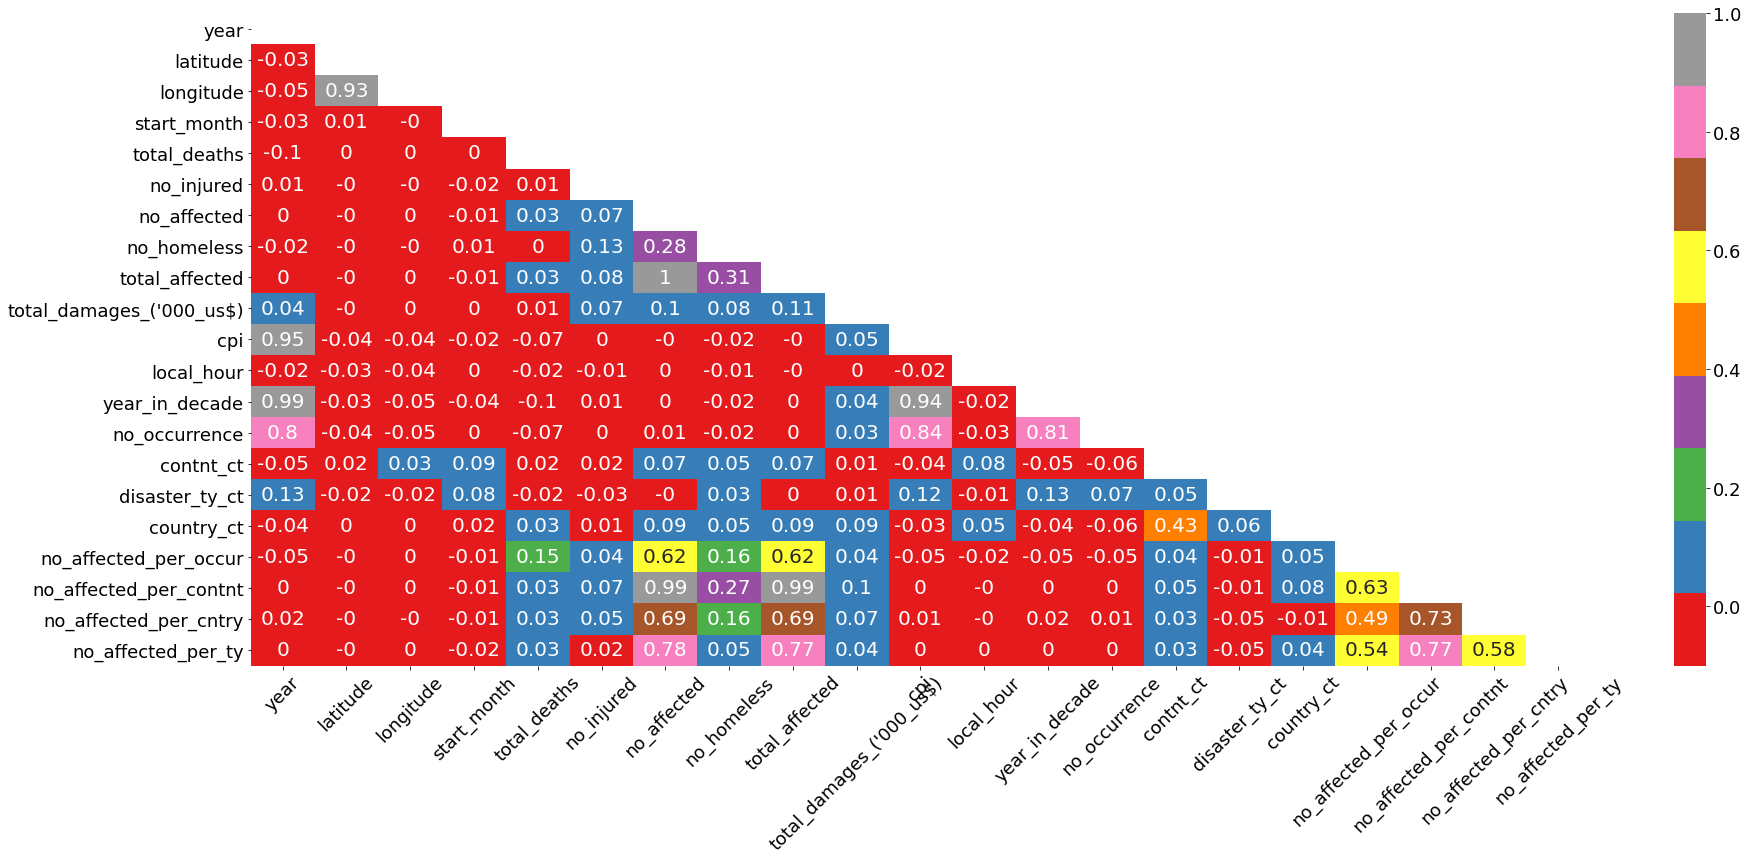

In [18]:
fig, ax = plt.subplots(figsize=(30,12))

# Correlation matrix
corr_matrix = df.corr()

# Plot chart
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(np.round(corr_matrix, 2), 
            annot=True, annot_kws={"size": 20},
            mask=mask, cmap=plt.get_cmap("Set1"), ax=ax)
plt.xticks(rotation=45)
plt.show()

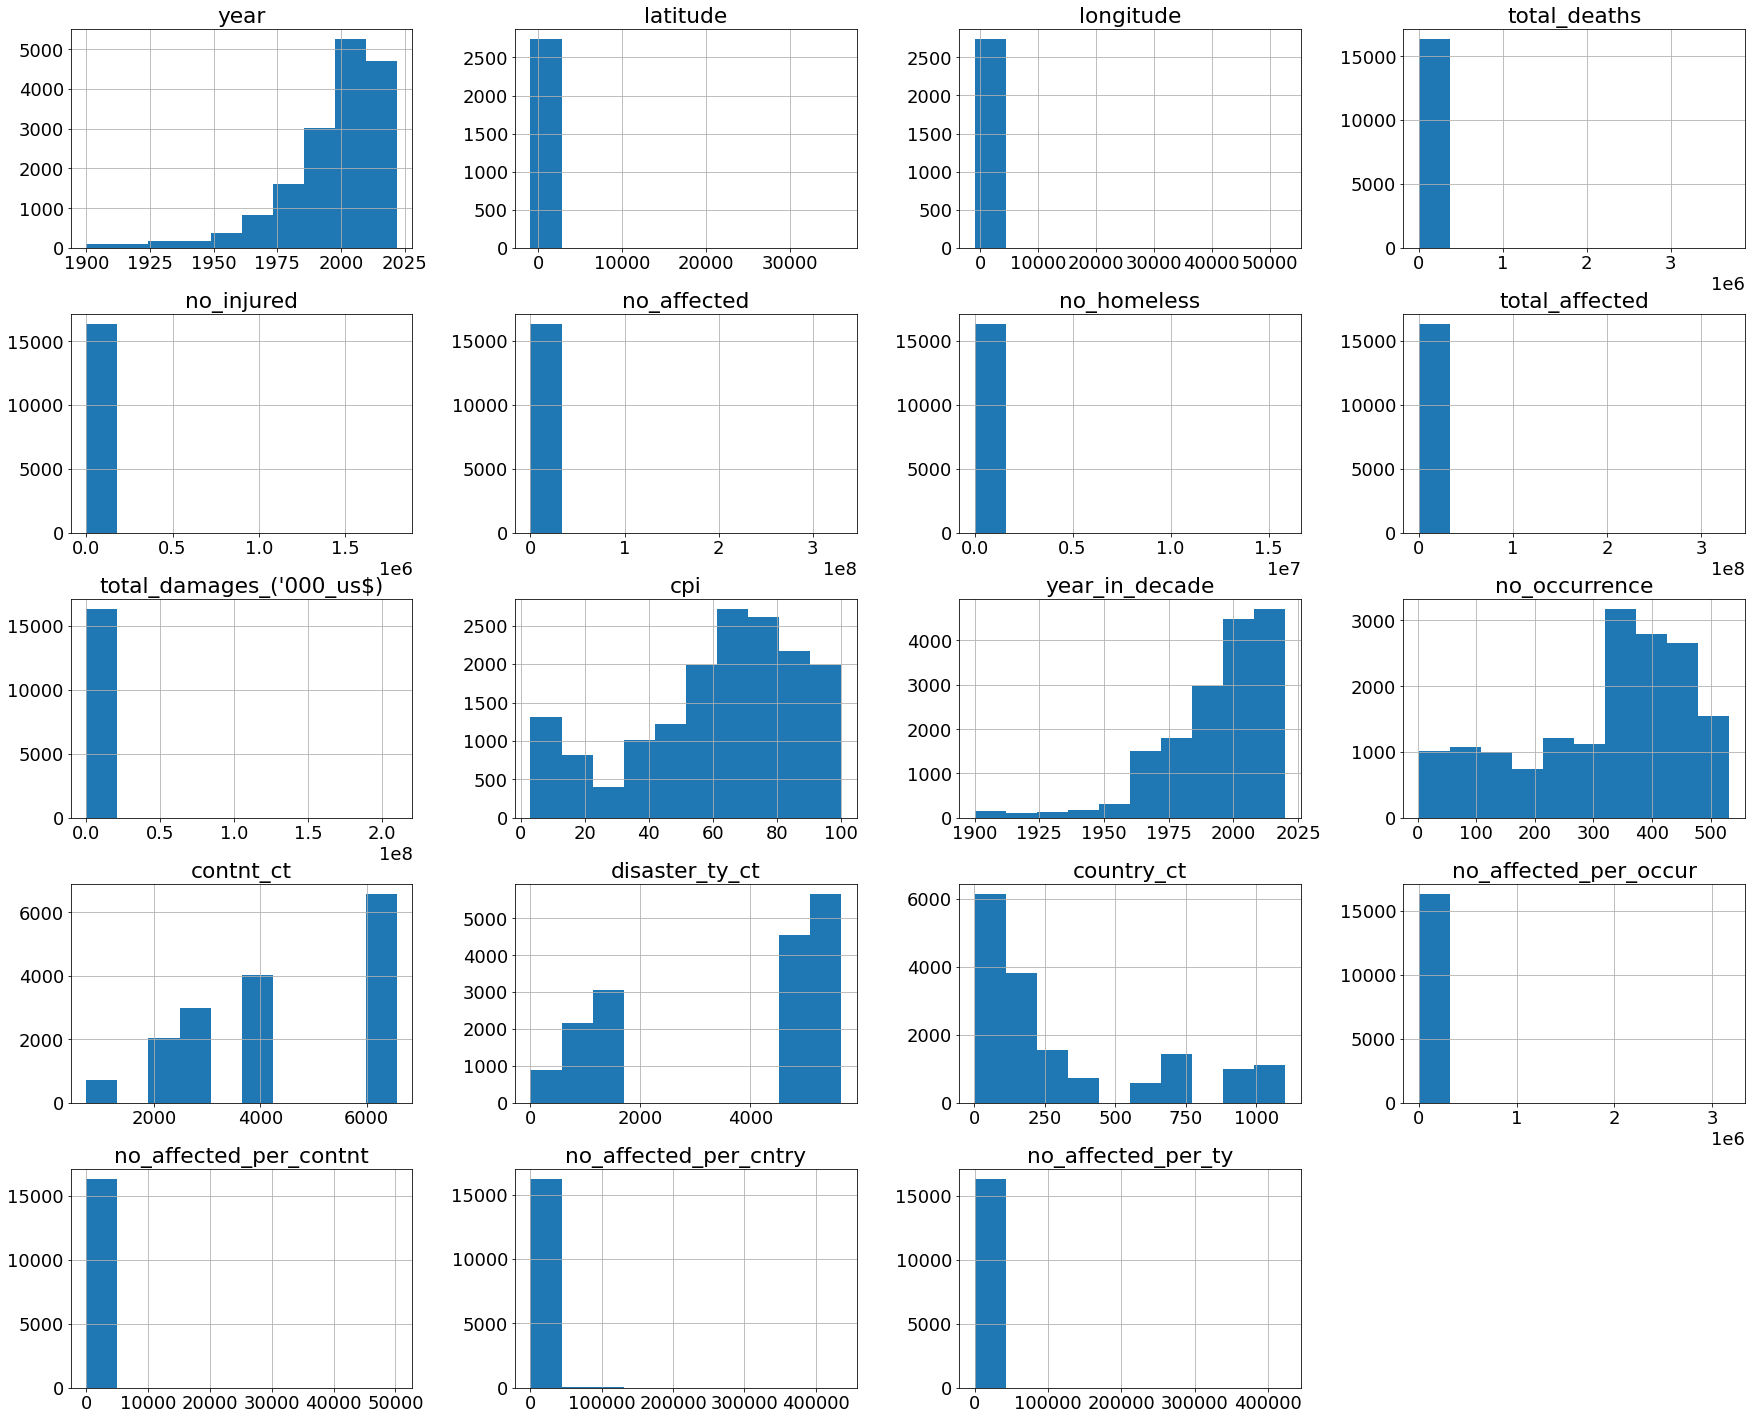

In [19]:
df.drop(['start_month', 'local_hour'], axis=1).hist(figsize=(30,25))
plt.show()

# Save as csv

In [20]:
df.to_csv('../data/ml_data.csv', index= False)